### Imports

In [1]:
# remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management 
import pandas as pd 
import numpy as np  
from pandas_datareader.data import DataReader 
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols 

# Feature engineering 
from sklearn.preprocessing import StandardScaler 

# Machine learning 
from sklearn.cluster import KMeans  
from sklearn import metrics 
from kneed import KneeLocator 

# Cointegration and Statistics 
from statsmodels.tsa.stattools import coint 
import statsmodels.api as sm 

# Reporting Visualization 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt  
import matplotlib.cm as cm 
%matplotlib inline

# data source 
import yfinance as yf


### Data Extraction

In [2]:
# Set data extraction parameters
start_date = '2017-01-01'
end_date = '2022-06-01'
file_name = 'data/raw_data_etf.csv'
file_name_coint = 'data/raw_data_coint_pairs.csv'
load_existing = False 
load_coint_pairs = True 

In [3]:
# Get New or load existing data 
# Allow 15 mins for new data

if not load_existing: 
    symbols = get_nasdaq_symbols()
    symbols = symbols[(symbols['ETF'] == True) & (symbols["Market Category"] == "G")]
    symbols = list(symbols.index.values)
    data = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]
    #data = DataReader(name=symbols, data_source='yahoo', start=start_date, end=end_date)["Adj Close"]
    data.to_csv(file_name)
                                                      
                                                  

[*********************100%%**********************]  567 of 567 completed


125 Failed downloads:
['BKIV', 'ETEC', 'AMZU', 'MKAM', 'FDFF', 'NVDU', 'NVDS', 'USVN', 'AMDS', 'CLOA', 'UNIY', 'BLLD', 'UTEN', 'NVD', 'UPWD', 'CALY', 'AMID', 'FBOT', 'SETM', 'CANC', 'DVAL', 'FBL', 'BSVO', 'BDGS', 'UTWO', 'STXG', 'BIGB', 'HCOW', 'TBIL', 'GGLL', 'STXD', 'UPGR', 'TSLL', 'MSFD', 'QQQS', 'ERET', 'BSCX', 'BSJU', 'UFIV', 'LGRO', 'SDSI', 'AAPD', 'PRVT', 'STXK', 'INFR', 'LZRD', 'BIGT', 'DIVD', 'VFLO', 'IBTM', 'MCSE', 'BSMW', 'BSSX', 'ILIT', 'PSWD', 'UTWY', 'QYLE', 'IBOT', 'EFRA', 'UTHY', 'USFI', 'JIVE', 'LITP', 'WABF', 'TSLS', 'RUNN', 'BSJV', 'JGLO', 'IWTR', 'IBTO', 'AOTG', 'ROE', 'MEDX', 'TMET', 'JPEF', 'FIXT', 'QQQY', 'FDIV', 'TSLQ', 'RNEW', 'COWS', 'FTGS', 'XFIX', 'MODL', 'PTEC', 'FDTX', 'PDBA', 'AMZD', 'FDIF', 'CIRC', 'OBIL', 'STXV', 'ICOP', 'TSL', 'CHPS', 'NIKL', 'AAPU', 'FDCF', 'SPAQ', 'NTZG', 'BABX', 'BSCW', 'SMRI', 'TSLR', 'COPJ', 'BRNY', 'MAXI', 'CONL', 'NVDD', 'COWG', 'TWEB', 'GGLS', 'NVDL', 'FMED', 'USCL', 'XBIL', 'BKWO', 'CAFG', 'URNJ', 'AAPB', 'DYTA', 'MSFU', 'CCS

In [4]:
# Load (or re-load for consistency) Data and remove features with Nan's
data = pd.read_csv(file_name)
data.dropna(axis=1, inplace=True)
data = data.set_index("Date")
print("Shape: ", data.shape)
print("Null Values: ", data.isnull().values.any())
data.head()

Shape:  (1362, 259)
Null Values:  False


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,38.378613,49.435776,52.544994,34.084595,14.575451,15.413176,41.399559,23.470148,8.890096,20.586910,...,92.907227,40.317547,106.940613,49.815815,91.773064,56.793961,38.054192,43.275078,47.666111,25.155083
2017-01-04 00:00:00,39.039196,49.925941,52.994392,34.463409,14.575451,15.448359,41.620762,23.816298,9.015062,20.651047,...,93.975021,40.333954,109.185883,50.562962,93.161552,57.020226,38.474190,43.713860,48.091232,25.482014
2017-01-05 00:00:00,39.457867,50.630005,53.197071,34.758034,14.575451,15.445160,42.133942,23.411966,9.082297,20.700928,...,93.804550,40.383160,108.345100,50.058765,91.905701,57.385258,38.762405,44.137543,48.055798,25.566080
2017-01-06 00:00:00,39.327614,50.380470,53.205887,34.614925,14.575451,15.432360,41.956978,23.411966,9.169774,20.722303,...,94.046814,40.317547,107.790932,49.847916,91.410461,57.224648,38.680058,43.903000,48.055798,25.612787
2017-01-09 00:00:00,39.467182,50.425030,53.082520,34.564430,14.575451,15.393991,42.072002,22.918873,9.110867,20.736559,...,93.723785,40.342148,107.724068,49.513287,90.304962,57.370651,38.605949,43.781952,47.745823,25.675375


### Markdown

In [5]:
# Create data frame with returns and volatility 
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,0.093047,0.233645
AAXJ,0.088006,0.211977
ACWI,0.117370,0.184689
ACWX,0.079741,0.183603
AGNG,0.125519,0.187271


In [6]:
# Scale Features 
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,-0.041481,0.298781
AAXJ,-0.104609,0.077469
ACWI,0.263104,-0.201251
ACWX,-0.208106,-0.212343
AGNG,0.365164,-0.174879


### K-Means Clustering

In [7]:
X = df_scaled.copy()
K = range(1, 15)
distortions = []

for k in K: 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    
k1 = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = k1.elbow
print("Optimum Clusters: ", c)

Optimum Clusters:  4


In [8]:
# Fit K-Means Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

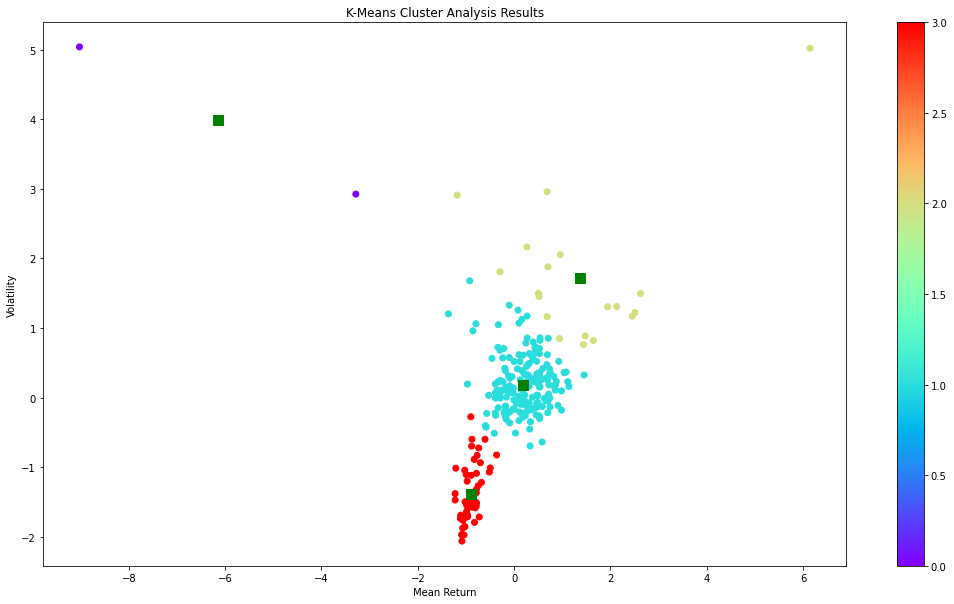

In [9]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")

plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [10]:
# return the series 
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series[:15]

AADR    1
AAXJ    1
ACWI    1
ACWX    1
AGNG    1
AGZD    3
AIA     1
AIRR    1
ALTY    1
ANGL    3
ASET    1
BBH     1
BFIT    1
BIB     2
BIS     0
dtype: int32

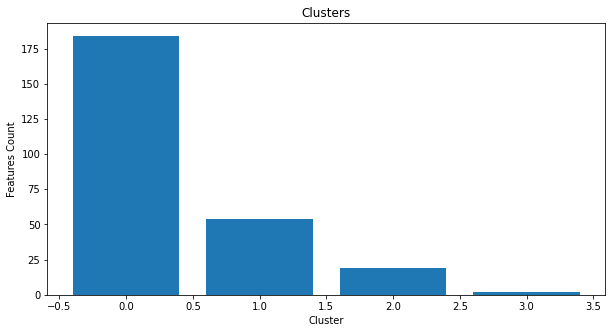

In [11]:
# view number by cluster 
plt.figure(figsize=(10,5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")
plt.show()

In [12]:
# remove items if preferred 
clusters_clean = clustered_series[clustered_series < 3]
print("Feature Number Previous: ", len(clustered_series))
print("Feature Number Current: ", len(clusters_clean))


Feature Number Previous:  259
Feature Number Current:  205


### Calculate Cointegration 

In [13]:
# Calculate cointegration 
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]
    model = sm.OLS(series_1, series_2).fit()
    headge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, headge_ratio

In [14]:
# Loop through and calculate cointegrated pairs
# Allow 10-30 mins for calculation
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs: 
    for base_asset in clusters_clean.index: 
        base_label = clusters_clean[base_asset]
        
        for compare_asset in clusters_clean.index: 
            compare_label = clusters_clean[compare_asset]
            
            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)
            
            if compare_asset != base_asset and base_label == compare_label and not is_tested: 
                
                series_1 = data[base_asset].values.astype(float)
                series_2 = data[compare_asset].values.astype(float)
                coint_flag, _ = calculate_cointegration(series_1, series_2)
                if coint_flag == 1:
                    cointegrated_pairs.append({"base_asset": base_asset, 
                                               "compare_asset": compare_asset, 
                                               "label": base_label})
                    
    df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
    df_coint.to_csv(file_name_coint)

In [40]:
# Load Cointegrated Pairs
df_coint = pd.read_csv(file_name_coint).iloc[:, 1:]
df_coint.head(60)

,base_asset,compare_asset,label
0,AADR,DAX,0
1,FKU,FTXR,0
2,FKU,SMCP,0
3,FKU,VTWV,0
4,FNX,INDY,0
5,FNX,PSCC,0
6,FPXI,IBB,0
7,FSZ,HEWG,0
8,FSZ,IXUS,0
9,FSZ,PFI,0


### TSNE Plot for Visualization


In [27]:
# Get unique list of cointegrated assets
coint_assets = [df_coint["base_asset"].values]
coint_assets.append(df_coint["compare_asset"].values)
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array(['AADR', 'AAXJ', 'ACWI', 'ACWX', 'AGNG'], dtype=object)

In [29]:
# Get TSNE only returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_unique_assets)]
df_TSNE.head()

,Returns,Volatility
AADR,-0.041481,0.298781
AAXJ,-0.104609,0.077469
ACWI,0.263104,-0.201251
ACWX,-0.208106,-0.212343
AGNG,0.365164,-0.174879


In [31]:
# Compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)
X_tsne


array([[ 10.687846  , -22.950544  ],
       [ 25.32953   , -18.819092  ],
       [-31.589056  ,   2.2911055 ],
       [ -3.7861633 ,  20.205032  ],
       [-33.36126   ,  -0.47334468],
       [ 43.680126  ,  22.845573  ],
       [ -9.032627  , -11.840937  ],
       [ 20.960846  ,  -7.1669736 ],
       [ 24.757116  ,  31.269098  ],
       [-11.862979  ,  23.714924  ],
       [  5.0517807 , -30.005642  ],
       [ 36.182987  ,  23.182354  ],
       [ 29.241585  ,  30.29361   ],
       [-37.32354   ,   5.563107  ],
       [-39.261303  ,  -5.620693  ],
       [-36.343327  ,   5.7820272 ],
       [  2.5289483 ,  23.987103  ],
       [ -9.407894  ,  22.567257  ],
       [  5.601012  ,  27.617403  ],
       [ -6.1249614 , -23.024616  ],
       [ -8.3428    , -22.065351  ],
       [ -8.649258  ,  13.68224   ],
       [ 15.864797  , -12.501055  ],
       [-11.635129  , -19.69054   ],
       [ 21.634964  , -10.499755  ],
       [ -0.6981168 , -26.71196   ],
       [-48.478848  ,  -5.649279  ],
 

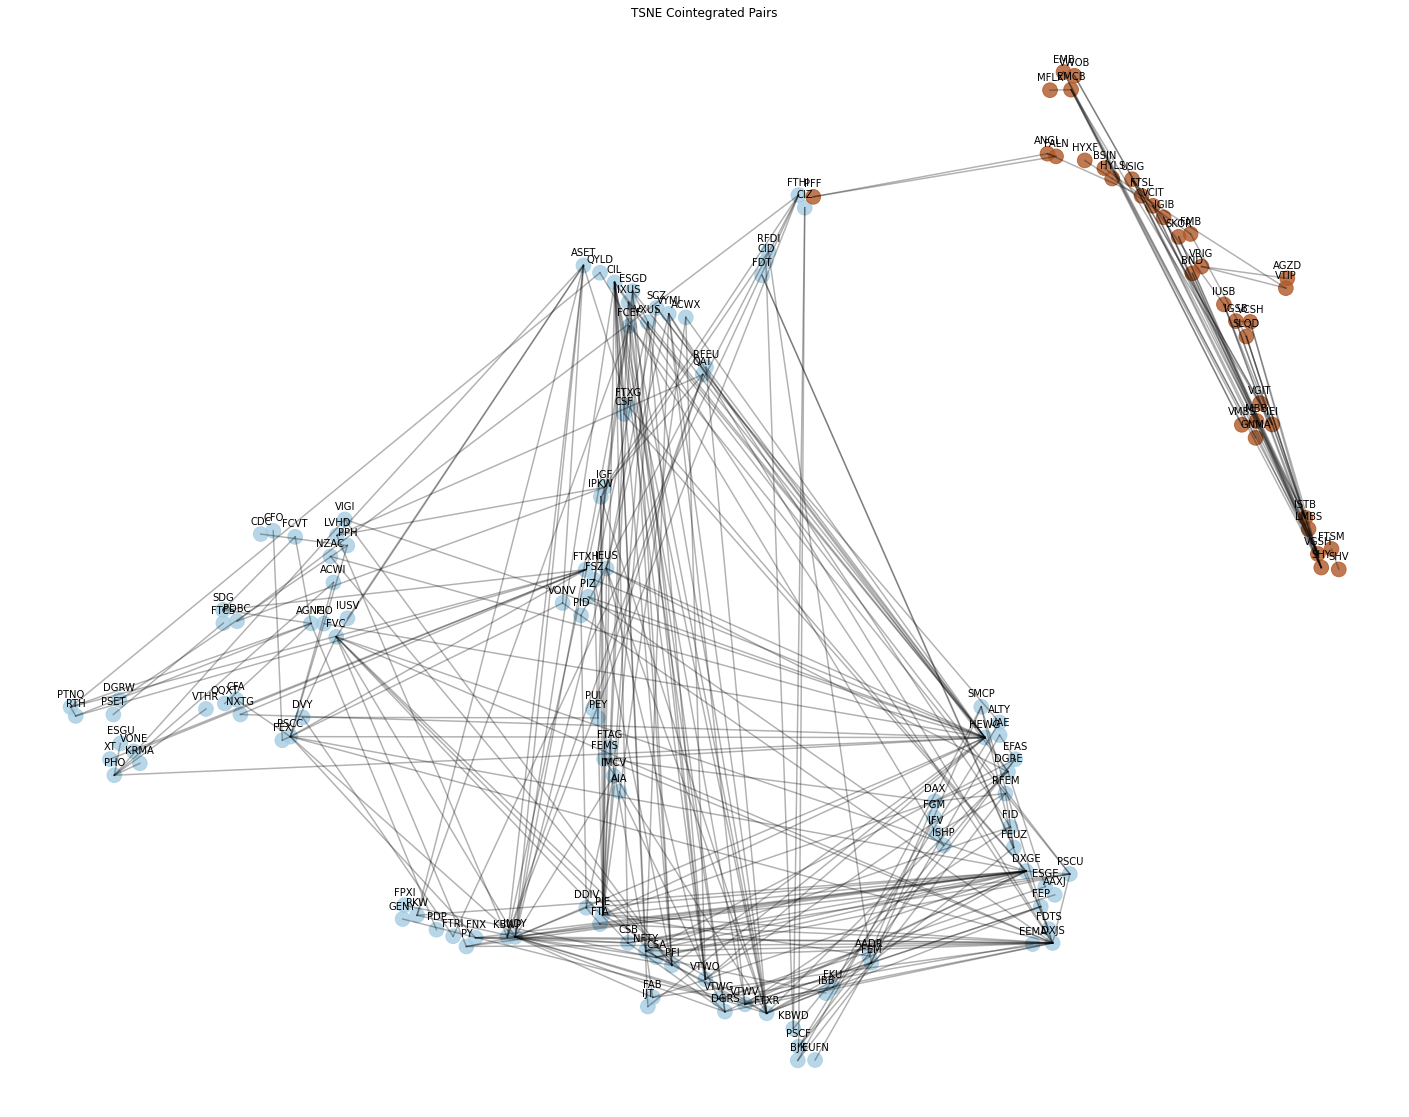

In [47]:
# Preview TSNE
in_pairs_series = clustered_series.loc[coint_unique_assets]
plt.figure(1, figsize=(25, 20))
plt.clf()
plt.axis('off')
for index, pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[1]  # Note: This should probably be ticker2 = pair[1] based on the context
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)  
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Cointegrated Pairs')

# Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha="center")
plt.show()


### Review a Pair

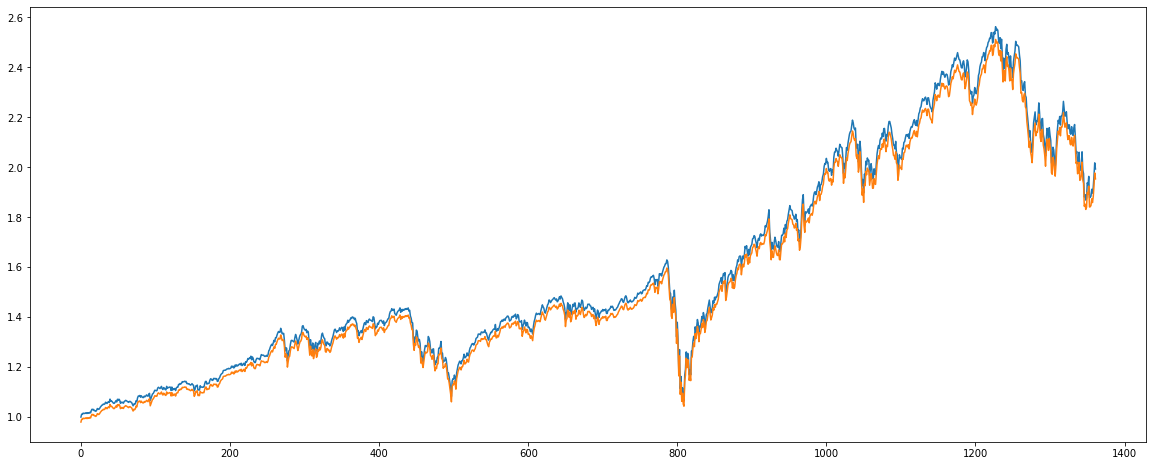

In [44]:
# Plot price comparison for any given assets
asset_1 = "FTC"
asset_2 = "PRN"
asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_1].values / data[asset_2].iloc[0].item()
plt.figure(1, figsize=(20, 8))
plt.plot(asset_1_values)
plt.plot(asset_2_values)
plt.show()

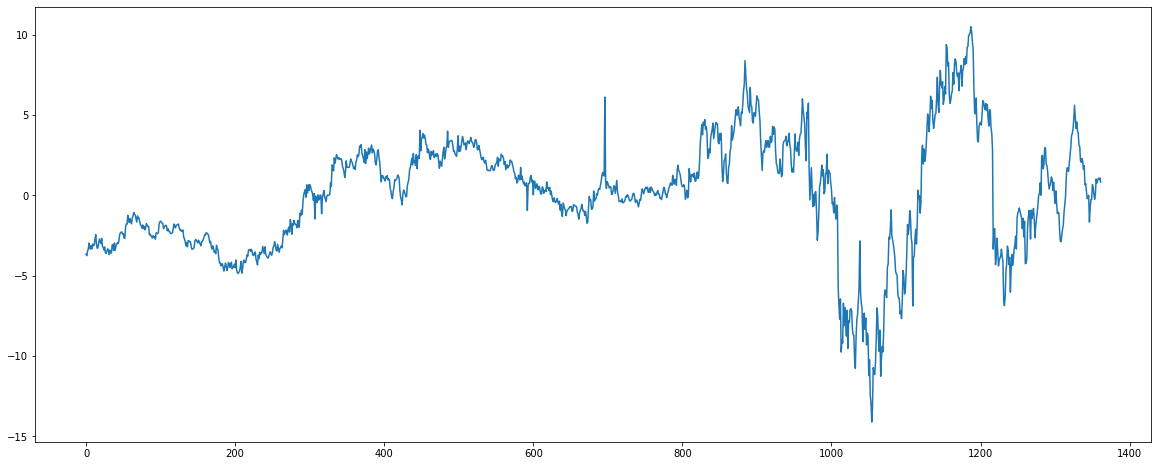

In [45]:
# Plot the Spread
series_1 = data[asset_1].values.astype(float)
series_2 = data[asset_2].values.astype(float)
coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
spread = series_1 - (hedge_ratio * series_2)
plt.figure(1, figsize=(20, 8))
plt.plot(spread)
plt.show()

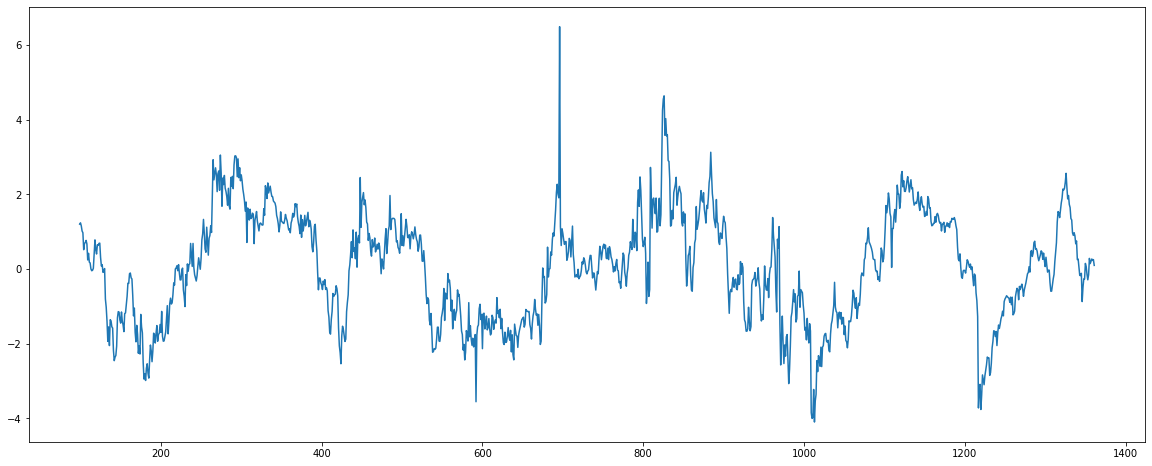

In [46]:
# Plot the Zscore 
window = 100
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std() # standard deviation
X = spread_series.rolling(center=False, window=1).mean()
z_score = (X - mean) / std
plt.figure(1, figsize=(20, 8))
plt.plot(z_score)
plt.show()